In [1]:
import numpy as np
import pandas as pd
import root_pandas
from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline

import ROOT as r
r.gROOT.LoadMacro('/belle2work/BelleII/belle2style/Belle2Style.C') 
r.SetBelle2Style()

# Make nice looking plots
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (12, 8),
})

train = '/belle2work/sbasil/lambdacpi0/fromBelleII/FastBDTs/train.root'
mccols = ["Xic_isSignal"]
df_train = root_pandas.read_root(train, key='xicp', columns=["K_kaonID_noSVD","p_protonID_noSVD","Lambdac_y","Xic_alpha","Xic_DeltaM"]+mccols)


Welcome to JupyROOT 6.24/06

Applying BELLE2 style settings...



In [2]:
test = '/belle2work/sbasil/lambdacpi0/fromBelleII/FastBDTs/test.root'
df_test = root_pandas.read_root(test, key='xicp', columns=["K_kaonID_noSVD","p_protonID_noSVD","Lambdac_y","Xic_alpha","Xic_DeltaM"]+mccols)

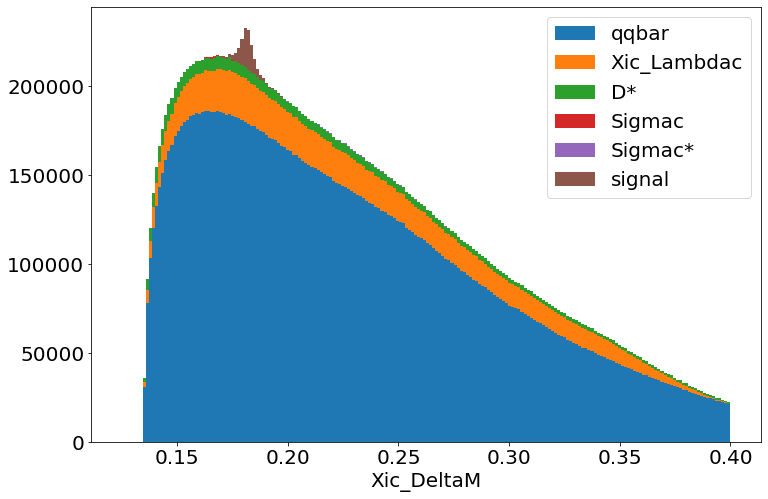

In [3]:
ax = plt.subplot()
cuts = "Xic_DeltaM > 0"
var = "Xic_DeltaM"

charmbgs = '((abs(Lambdac_mcPDG)==411 and abs(Lambdac_genMotherPDG)==413) or (abs(Lambdac_mcPDG)==421 and abs(Lambdac_genMotherPDG)==423) or (abs(Lambdac_mcPDG)==431 and abs(Lambdac_genMotherPDG)==433))'
sigmast = '(pi0_mcPDG==111 and Lambdac_isSignal==1 and ((abs(Lambdac_genMotherPDG)==4212 and abs(pi0_genMotherPDG)==4212)))'
sigmastst = '(pi0_mcPDG==111 and Lambdac_isSignal==1 and ((abs(Lambdac_genMotherPDG)==4214 and abs(pi0_genMotherPDG)==4214)))'

npqq = df_train.query(cuts+' and not Xic_isSignal==1 and not Lambdac_isSignal==1 and not '+charmbgs+' and not '+sigmast+' and not '+sigmastst)[var].to_numpy()
npcc1 = df_train.query(cuts+' and not Xic_isSignal==1 and '+charmbgs)[var].to_numpy()
npcc2 = df_train.query(cuts+' and not Xic_isSignal==1 and '+sigmast)[var].to_numpy()
npcc3 = df_train.query(cuts+' and not Xic_isSignal==1 and '+sigmastst)[var].to_numpy()
npLc = df_train.query(cuts+' and not Xic_isSignal==1 and Lambdac_isSignal==1 and not '+charmbgs+' and not '+sigmast+' and not '+sigmastst)[var].to_numpy()
nptrue = df_train.query(cuts+' and Xic_isSignal==1')[var].to_numpy()

ax.hist([npqq,npLc,npcc1,npcc2,npcc3,nptrue], bins=200, range=(0.125,0.4),
        label=["qqbar","Xic_Lambdac","D*","Sigmac","Sigmac*","signal"], stacked=True)


plt.xlabel("Xic_DeltaM")
plt.legend(loc=0)
plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Load the train.csv and test.csv datasets
train_data = df_train
test_data = df_test

for c in train_data.columns:
    train_data[c] = np.nan_to_num(train_data[c], copy = False)

for c in test_data.columns:
    test_data[c] = np.nan_to_num(test_data[c], copy = False)

X_train = train_data.drop(columns=mccols+["Xic_DeltaM"])
y_train = train_data["Xic_isSignal"]

X_test = test_data.drop(columns=mccols+["Xic_DeltaM"])
y_test = test_data["Xic_isSignal"]

#class_counts = y_train.value_counts()

#total_samples = len(y_train)
#class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight = 'balanced')

# Train the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [36]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

lr_model1 = LogisticRegression(class_weight = 'balanced')
lr_model1.fit(X_train_scaled, y_train)

predictions1 = lr_model1.predict(X_train_scaled)

X_train_stacked = np.column_stack((X_train_scaled, predictions1))

decision_tree_model2 = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')
decision_tree_model2.fit(X_train_stacked, y_train)

predictions1_test = lr_model1.predict(X_test_scaled)
X_test_stacked = np.column_stack((X_test_scaled, predictions1_test))

predictions2 = decision_tree_model2.predict(X_test_stacked)

ensemble_accuracy = accuracy_score(y_test, predictions2)
print("Ensemble Accuracy:", ensemble_accuracy)


Ensemble Accuracy: 0.9915242996289727


In [28]:
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8375027407656096
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91  23085033
         1.0       0.02      0.84      0.04     97358

    accuracy                           0.84  23182391
   macro avg       0.51      0.84      0.48  23182391
weighted avg       1.00      0.84      0.91  23182391



In [37]:
X_test["Lambdac_y"] = test_data["Lambdac_y"]
X_test["K_kaonID_noSVD"] = test_data["K_kaonID_noSVD"]
X_test["p_protonID_noSVD"] = test_data["p_protonID_noSVD"]
X_test["Xic_alpha"] = test_data["Xic_alpha"]
X_test["Xic_DeltaM"] = test_data["Xic_DeltaM"]
X_test["Xic_isSignal"] = test_data["Xic_isSignal"]


#for v in ["Lambdac_isSignal","Lambdac_mcPDG","Lambdac_genMotherPDG","pi0_mcPDG","pi0_genMotherPDG"]:
    #X_test[v] = test_data[v]

"""
# Create a DataFrame with the true labels, predicted labels, and other features (e.g., "distance")
predictions_df = pd.DataFrame({"pred": y_pred,
                               "Xic_isSignal": X_test["Xic_isSignal"],
                               "Lambdac_y": X_test["Lambdac_y"],
                               "K_kaonID_noSVD": X_test["K_kaonID_noSVD"],
                               "p_protonID_noSVD": X_test["p_protonID_noSVD"],
                               "Xic_alpha": X_test["Xic_alpha"],
                               "Xic_DeltaM": X_test["Xic_DeltaM"],
                               "Lambdac_isSignal": X_test["Lambdac_isSignal"],
                               "Lambdac_mcPDG": X_test["Lambdac_mcPDG"],
                               "Lambdac_genMotherPDG": X_test["Lambdac_genMotherPDG"],
                               "pi0_mcPDG": X_test["pi0_mcPDG"],
                               "pi0_genMotherPDG": X_test["pi0_genMotherPDG"]
                              })
"""

predictions_df = pd.DataFrame({"pred": predictions2,
                               "Xic_isSignal": X_test["Xic_isSignal"],
                               "Xic_DeltaM": X_test["Xic_DeltaM"],
                              })

In [38]:
predictions_df = predictions_df.query("pred > 0")

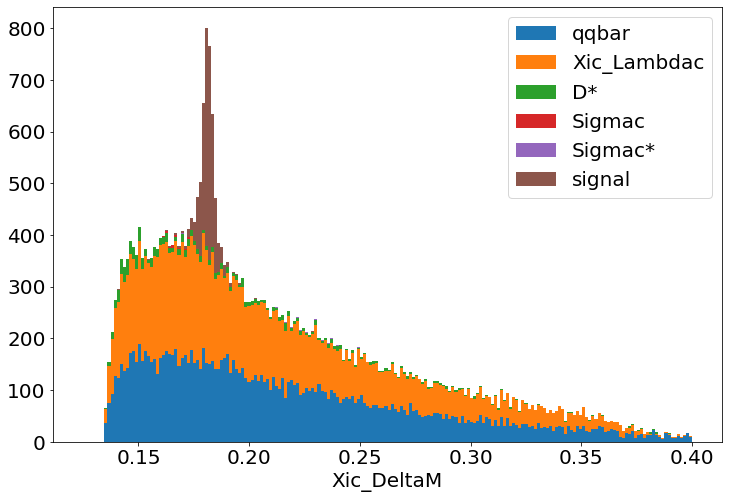

In [29]:
ax = plt.subplot()
cuts = "Xic_DeltaM > 0"
var = "Xic_DeltaM"

charmbgs = '((abs(Lambdac_mcPDG)==411 and abs(Lambdac_genMotherPDG)==413) or (abs(Lambdac_mcPDG)==421 and abs(Lambdac_genMotherPDG)==423) or (abs(Lambdac_mcPDG)==431 and abs(Lambdac_genMotherPDG)==433))'
sigmast = '(pi0_mcPDG==111 and Lambdac_isSignal==1 and ((abs(Lambdac_genMotherPDG)==4212 and abs(pi0_genMotherPDG)==4212)))'
sigmastst = '(pi0_mcPDG==111 and Lambdac_isSignal==1 and ((abs(Lambdac_genMotherPDG)==4214 and abs(pi0_genMotherPDG)==4214)))'

npqq = predictions_df.query(cuts+' and not Xic_isSignal==1 and not Lambdac_isSignal==1 and not '+charmbgs+' and not '+sigmast+' and not '+sigmastst)[var].to_numpy()
npcc1 = predictions_df.query(cuts+' and not Xic_isSignal==1 and '+charmbgs)[var].to_numpy()
npcc2 = predictions_df.query(cuts+' and not Xic_isSignal==1 and '+sigmast)[var].to_numpy()
npcc3 = predictions_df.query(cuts+' and not Xic_isSignal==1 and '+sigmastst)[var].to_numpy()
npLc = predictions_df.query(cuts+' and not Xic_isSignal == 1 and Lambdac_isSignal==1 and not '+charmbgs+' and not '+sigmast+' and not '+sigmastst)[var].to_numpy()
nptrue = predictions_df.query(cuts + ' and Xic_isSignal == 1')[var].to_numpy()

ax.hist([npqq,npLc,npcc1,npcc2,npcc3,nptrue], bins=200, range=(0.125,0.4),
        label=["qqbar","Xic_Lambdac","D*","Sigmac","Sigmac*","signal"], stacked=True)

#ax.hist([nptrue], bins=200, range=(0.125,0.4),
        #label=["signal"], stacked=True)
    
    
    
plt.xlabel("Xic_DeltaM")
plt.legend(loc=0)
plt.show()

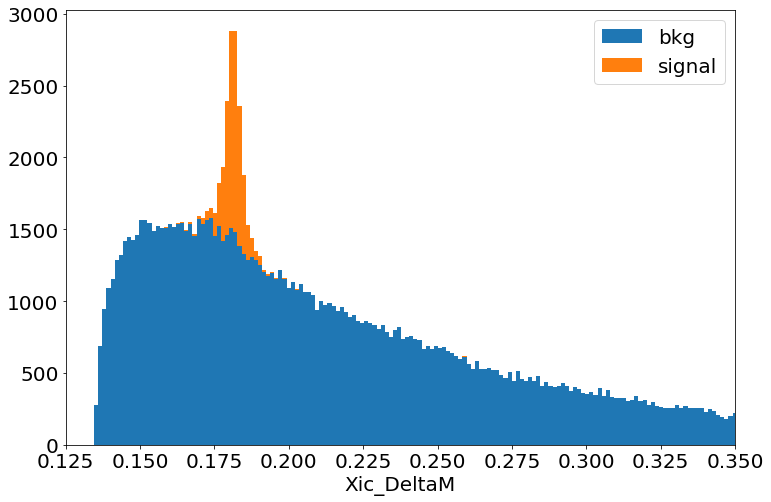

In [35]:
ax = plt.subplot()
cuts = "Xic_DeltaM > 0"
var = "Xic_DeltaM"

charmbgs = '((abs(Lambdac_mcPDG)==411 and abs(Lambdac_genMotherPDG)==413) or (abs(Lambdac_mcPDG)==421 and abs(Lambdac_genMotherPDG)==423) or (abs(Lambdac_mcPDG)==431 and abs(Lambdac_genMotherPDG)==433))'
sigmast = '(pi0_mcPDG==111 and Lambdac_isSignal==1 and ((abs(Lambdac_genMotherPDG)==4212 and abs(pi0_genMotherPDG)==4212)))'
sigmastst = '(pi0_mcPDG==111 and Lambdac_isSignal==1 and ((abs(Lambdac_genMotherPDG)==4214 and abs(pi0_genMotherPDG)==4214)))'

npbkg = predictions_df.query(cuts + ' and Xic_isSignal == 0')[var].to_numpy()
nptrue = predictions_df.query(cuts + ' and Xic_isSignal == 1')[var].to_numpy()

ax.hist([npbkg,nptrue], bins=200, range=(0.125,0.4),
        label=["bkg","signal"], stacked=True)

#ax.hist([nptrue], bins=200, range=(0.125,0.4),
        #label=["signal"], stacked=True)
    
    
    
plt.xlabel("Xic_DeltaM")
plt.legend(loc=0)
plt.xlim((0.125,0.35))
plt.show()

